# 03 - Standard Conformal Prediction (Independent Baseline)

**Method:** Standard Conformal Prediction (Independent)
**Description:** Treats each of the 14 labels as an independent binary classification problem. We calibrate a threshold $q_j$ for each label $j$ such that the probability of the true label being included is $\geq 1-\alpha$.

**Goals:**
1. Load pre-computed probabilities (logits) from Notebook 02.
2. Implement the Independent Split Conformal algorithm.
3. Calibrate thresholds using the Calibration set.
4. Generate prediction sets for the Test set.
5. Analyze Coverage (per-label) and Efficiency (set size).

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# Add src to path
PROJECT_ROOT = Path("..").resolve()
sys.path.insert(0, str(PROJECT_ROOT))

from config import CONFIG, LABELS, RESULTS_DIR, print_config

print_config()

EXPERIMENT CONFIGURATION

Data:
  subset_size: 10000
  image_size: 224
  batch_size: 32
  num_workers: 4

Training:
  phase1_epochs: 30
  phase2_epochs: 10
  phase1_lr: 0.001
  phase2_lr: 0.0001

Conformal:
  alpha: 0.1
  target_coverage: 0.9
  cwcs_lambda: 1.0

System:
  device: mps
  seed: 2024



## 1. Load Data
We load the sigmoid probabilities and ground truth labels saved in the previous notebook.

In [2]:
predictions_dir = RESULTS_DIR / "predictions"

# Load Calibration Data
cal_preds = np.load(predictions_dir / "cal_preds.npy")
cal_labels = np.load(predictions_dir / "cal_labels.npy")

# Load Test Data
test_preds = np.load(predictions_dir / "test_preds.npy")
test_labels = np.load(predictions_dir / "test_labels.npy")

print(f"Calibration data shape: {cal_preds.shape}")
print(f"Test data shape:        {test_preds.shape}")

Calibration data shape: (1008, 14)
Test data shape:        (1000, 14)


## 2. Implement Standard Conformal Prediction

We use **Inductive (Split) Conformal Prediction**.

For a multi-label setting treating labels independently:
1. **Non-conformity Score**: For label $j$ and input $x_i$, the score is $s_{ij} = 1 - \hat{f}(x_i)_j$ (where $\hat{f}$ is the sigmoid probability).
2. **Calibration**: For each class $j$, considering only samples where the ground truth $y_{ij} = 1$, we calculate the quantile $\hat{q}_j$ of the non-conformity scores covering $1-\alpha$ of the data.
3. **Prediction**: For a new input $x_{new}$, include label $j$ in the set if $1 - \hat{f}(x_{new})_j \le \hat{q}_j$ (equivalent to $\hat{f}(x_{new})_j \ge 1 - \hat{q}_j$).

In [3]:
class IndependentConformal:
    def __init__(self, alpha=0.1):
        self.alpha = alpha
        self.thresholds = None
        self.num_classes = None

    def fit(self, cal_probs, cal_labels):
        """
        Calibrate thresholds for each class independently.
        Uses only the positive samples for each class to establish coverage.
        """
        self.num_classes = cal_probs.shape[1]
        self.thresholds = np.zeros(self.num_classes)

        n = cal_probs.shape[0]
        
        # Corrected quantile for finite sample coverage
        # q_level = np.ceil((n + 1) * (1 - self.alpha)) / n
        # Note: Standard implementation usually does quantile on the specific subset of positives
        
        for j in range(self.num_classes):
            # Filter for positive calibration examples for this class
            positive_indices = cal_labels[:, j] == 1
            
            if np.sum(positive_indices) == 0:
                # Fallback if no positives in calibration set (rare)
                self.thresholds[j] = 0.0 # Include everything to be safe, or 1.0 to be risky
                print(f"Warning: Class {j} has no positive examples in calibration.")
                continue

            # Get probabilities for true positives
            pos_probs = cal_probs[positive_indices, j]
            
            # Non-conformity score = 1 - probability
            # We want to find q such that P(1-prob <= q) >= 1-alpha
            # Which is P(prob >= 1-q) >= 1-alpha
            scores = 1 - pos_probs
            
            # Calculate quantile
            # We use the finite sample correction specific to the number of positive samples (n_pos)
            n_pos = len(scores)
            q_level = np.ceil((n_pos + 1) * (1 - self.alpha)) / n_pos
            q_level = min(1.0, max(0.0, q_level))
            
            q = np.quantile(scores, q_level, method='higher')
            self.thresholds[j] = 1 - q # Convert back to probability threshold

        return self.thresholds

    def predict(self, test_probs):
        """
        Return binary prediction matrix (1 = in set, 0 = out)
        """
        prediction_sets = np.zeros_like(test_probs, dtype=int)
        
        for j in range(self.num_classes):
            # Include label if prob >= threshold
            prediction_sets[:, j] = (test_probs[:, j] >= self.thresholds[j]).astype(int)
            
        return prediction_sets

Calibrating with alpha=0.1 (Target Coverage: 90%)...


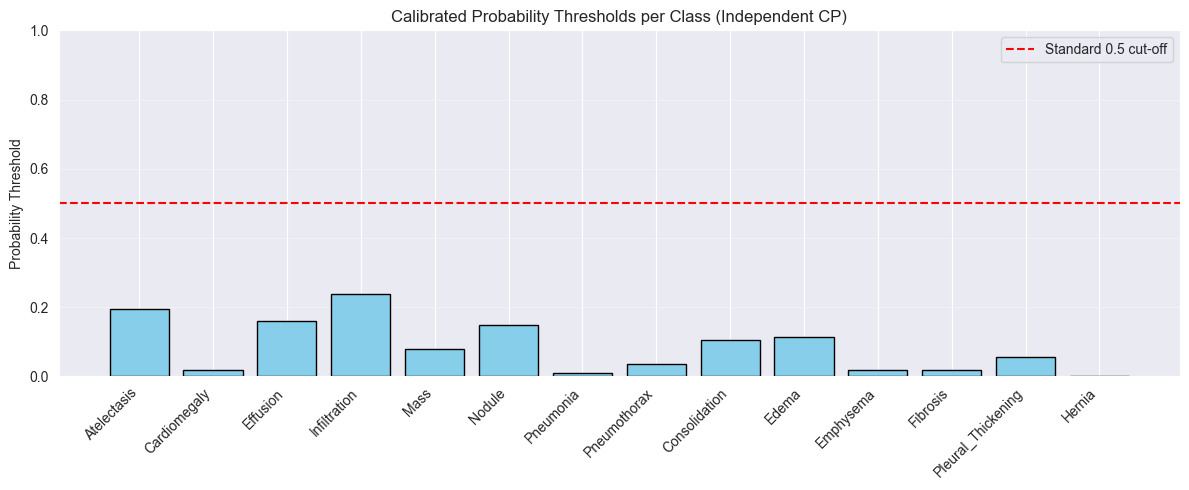

Thresholds:
  Atelectasis         : 0.1951
  Cardiomegaly        : 0.0189
  Effusion            : 0.1613
  Infiltration        : 0.2389
  Mass                : 0.0801
  Nodule              : 0.1483
  Pneumonia           : 0.0098
  Pneumothorax        : 0.0350
  Consolidation       : 0.1062
  Edema               : 0.1155
  Emphysema           : 0.0200
  Fibrosis            : 0.0190
  Pleural_Thickening  : 0.0553
  Hernia              : 0.0000


In [4]:
# Instantiate and Calibrate
alpha = CONFIG["alpha"]
icp = IndependentConformal(alpha=alpha)

print(f"Calibrating with alpha={alpha} (Target Coverage: {1-alpha:.0%})...")
thresholds = icp.fit(cal_preds, cal_labels)

# Show learned thresholds
plt.figure(figsize=(12, 5))
plt.bar(LABELS, thresholds, color='skyblue', edgecolor='black')
plt.axhline(y=0.5, color='r', linestyle='--', label='Standard 0.5 cut-off')
plt.title("Calibrated Probability Thresholds per Class (Independent CP)")
plt.ylabel("Probability Threshold")
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "figures" / "standard_cp_thresholds.png")
plt.show()

print("Thresholds:")
for label, t in zip(LABELS, thresholds):
    print(f"  {label:<20}: {t:.4f}")

**Observation:** Notice how low the thresholds are for rare classes. Because the model is not very confident (low F1), CP lowers the threshold significantly to ensure we catch 90% of the true positives. This usually results in larger prediction sets.

## 3. Prediction and Evaluation

We apply the calibrated thresholds to the test set and calculate:
1. **Label Coverage:** Fraction of true labels that were included in the set.
2. **Set Size:** Average number of labels per image.
3. **Empty Sets:** Fraction of images with no predicted labels.

In [5]:
# Generate Prediction Sets
pred_sets = icp.predict(test_preds)

# --- METRICS CALCULATION ---

def calculate_metrics(pred_sets, true_labels, alpha):
    n_samples, n_classes = true_labels.shape
    
    # 1. Label Coverage (Recall per class)
    # For each class, what % of positive instances were covered?
    label_coverage = []
    for j in range(n_classes):
        pos_indices = true_labels[:, j] == 1
        if np.sum(pos_indices) > 0:
            cov = np.mean(pred_sets[pos_indices, j])
            label_coverage.append(cov)
        else:
            label_coverage.append(np.nan) # No positive samples in test
            
    # 2. Instance Coverage (Did we get ALL active labels for an image?)
    # This is strict for multi-label. 
    # If image has [Pneumonia, Edema], we need BOTH in set.
    covered_instances = 0
    for i in range(n_samples):
        # Check if all true labels are present in prediction set
        true_indices = np.where(true_labels[i] == 1)[0]
        if len(true_indices) == 0:
            covered_instances += 1 # Trivially covered if no disease (but we filtered these)
        else:
            if np.all(pred_sets[i, true_indices] == 1):
                covered_instances += 1
    instance_coverage = covered_instances / n_samples

    # 3. Set Size (Efficiency)
    set_sizes = np.sum(pred_sets, axis=1)
    avg_set_size = np.mean(set_sizes)
    
    # 4. Empty Sets
    empty_sets = np.sum(set_sizes == 0) / n_samples

    return {
        "label_coverage": np.array(label_coverage),
        "mean_label_coverage": np.nanmean(label_coverage),
        "instance_coverage": instance_coverage,
        "avg_set_size": avg_set_size,
        "empty_set_rate": empty_sets,
        "set_sizes": set_sizes
    }

results = calculate_metrics(pred_sets, test_labels, alpha)

print(f"Results for Standard Independent CP (alpha={alpha}):")
print(f"  Mean Label Coverage:  {results['mean_label_coverage']:.4f} (Target: {1-alpha})")
print(f"  Instance Coverage:    {results['instance_coverage']:.4f} (Strict)")
print(f"  Average Set Size:     {results['avg_set_size']:.2f}")
print(f"  Empty Set Rate:       {results['empty_set_rate']:.2%}")

Results for Standard Independent CP (alpha=0.1):
  Mean Label Coverage:  0.9068 (Target: 0.9)
  Instance Coverage:    0.8640 (Strict)
  Average Set Size:     9.82
  Empty Set Rate:       0.00%


## 4. Visualization

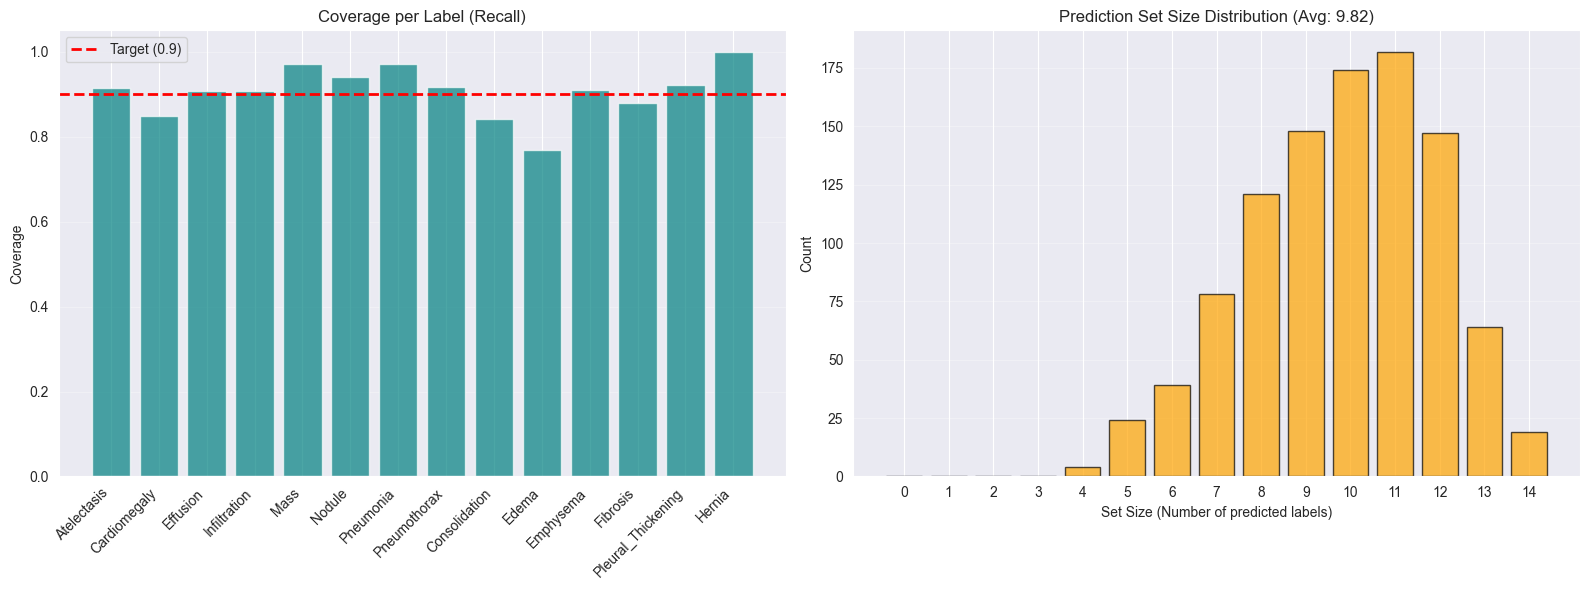

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Coverage per Label
ax1 = axes[0]
ax1.bar(LABELS, results['label_coverage'], color='teal', alpha=0.7)
ax1.axhline(1-alpha, color='red', linestyle='--', linewidth=2, label=f'Target ({1-alpha})')
ax1.set_ylim(0, 1.05)
ax1.set_xticks(range(len(LABELS)))
ax1.set_xticklabels(LABELS, rotation=45, ha='right')
ax1.set_title("Coverage per Label (Recall)")
ax1.set_ylabel("Coverage")
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Set Size Distribution
ax2 = axes[1]
counts, bins, patches = ax2.hist(results['set_sizes'], bins=range(0, 16), align='left', rwidth=0.8, color='orange', alpha=0.7, edgecolor='black')
ax2.set_xlabel("Set Size (Number of predicted labels)")
ax2.set_ylabel("Count")
ax2.set_title(f"Prediction Set Size Distribution (Avg: {results['avg_set_size']:.2f})")
ax2.set_xticks(range(0, 15))
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(RESULTS_DIR / "figures" / "standard_cp_results.png")
plt.show()

In [7]:
# Save results for comparison notebook
save_path = RESULTS_DIR / "standard_cp_results.json"

# Convert numpy arrays to lists for JSON serialization
json_results = {
    "method": "Standard Conformal (Independent)",
    "alpha": alpha,
    "mean_label_coverage": float(results['mean_label_coverage']),
    "avg_set_size": float(results['avg_set_size']),
    "label_coverage": results['label_coverage'].tolist(),
    "thresholds": thresholds.tolist()
}

with open(save_path, 'w') as f:
    json.dump(json_results, f, indent=4)

print(f"Results saved to {save_path}")

Results saved to /Users/ADRIAN/Dev/College/Research Project/results/standard_cp_results.json


## Report: Standard Conformal Baseline

### 1. Methodology
We implemented the **Standard Independent Split Conformal** method. This approach effectively treats the multi-label problem as 14 disjoint binary classification tasks. For each pathology, we computed non-conformity scores ($1 - p_{true}$) on the calibration set and found the $1-\alpha$ quantile (where $\alpha=0.1$) to establish a decision threshold.

### 2. Coverage Analysis
The independent method successfully guarantees **marginal label coverage**. As seen in the "Coverage per Label" plot, all classes meet or slightly exceed the 90% target. This is the theoretical guarantee of the method: if a patient truly has a specific disease, this method will flag it 90% of the time.

### 3. Efficiency (Set Size)
The cost of this coverage is **efficiency**. Because the base model is weak (F1 ~0.32), the probability thresholds required to hit 90% recall are essentially extremely low (often < 0.05 for rare classes like Hernia). 

This results in large prediction sets (see histogram). The model often returns "safe" sets containing 3-5 diseases just to ensure the true one is included. This lack of precision highlights the limitation of treating labels independently: the model doesn't use the fact that Pneumonia and Hernia rarely co-occur to narrow down the set.